<a href="https://colab.research.google.com/github/anurag25/shared_notebooks/blob/master/Jigsaw_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *
from fastai.callbacks import *
from fastai.utils import *
from fastai.callbacks.mem import PeakMemMetric

import warnings
warnings.filterwarnings("ignore")

In [5]:
device = torch.cuda.set_device(0)
print(torch.cuda.get_device_name(device))

Tesla P100-PCIE-16GB


In [6]:
show_install(show_nvidia_smi = True)



```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.61
fastprogress  : 0.2.3
torch         : 1.5.0+cu101
nvidia driver : 418.67
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16280MB | Tesla P100-PCIE-16GB

=== Environment === 
platform      : Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Feb 19 05:26:34 PST 2020
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython

Sat May 30 13:20:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+-----------------

In [7]:
path_in = Path("/content/gdrive/My Drive/kaggle_data/jigsaw/input")
path_out = Path("/content/gdrive/My Drive/kaggle_data/jigsaw/output")
path_mod = Path("/content/gdrive/My Drive/kaggle_data/jigsaw/model")
path_in.ls()

[PosixPath('/content/gdrive/My Drive/kaggle_data/jigsaw/input/jigsaw-toxic-comment-train.csv'),
 PosixPath('/content/gdrive/My Drive/kaggle_data/jigsaw/input/validation.csv'),
 PosixPath('/content/gdrive/My Drive/kaggle_data/jigsaw/input/test.csv'),
 PosixPath('/content/gdrive/My Drive/kaggle_data/jigsaw/input/validation.csv.zip'),
 PosixPath('/content/gdrive/My Drive/kaggle_data/jigsaw/input/jigsaw-toxic-comment-train.csv.zip'),
 PosixPath('/content/gdrive/My Drive/kaggle_data/jigsaw/input/sample_submission.csv'),
 PosixPath('/content/gdrive/My Drive/kaggle_data/jigsaw/input/test.csv.zip'),
 PosixPath('/content/gdrive/My Drive/kaggle_data/jigsaw/input/sample_train.csv'),
 PosixPath('/content/gdrive/My Drive/kaggle_data/jigsaw/input/lm_text.csv')]

In [8]:
train_df = pd.read_csv(path_in/"sample_train.csv")
print(len(train_df))
train_df.head()

22355


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0a09f916ce6e77ce,""", 22 January 2011 (UTC) \n :::::BLP? In any ...",0,0,0,0,0,0
1,c27b11ee01f9769d,You DL the videos from here actually.. http://...,0,0,0,0,0,0
2,388e696b7672dc8c,::You're a troll. Delete away.,0,0,0,0,1,0
3,90b401755e15f325,""" \n\n Please do not vandalize pages, as you ...",0,0,0,0,0,0
4,ee66e5bc910e5a36,I reckon there is an argument for it - it is ...,0,0,0,0,0,0


In [9]:
train_df.toxic.value_counts()

0    20217
1     2138
Name: toxic, dtype: int64

In [9]:
valid_df = pd.read_csv(path_in/"validation.csv")
print(len(valid_df))
valid_df.head()

8000


,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [11]:
print(valid_df.lang.value_counts())
print(valid_df.toxic.value_counts())

tr    3000
es    2500
it    2500
Name: lang, dtype: int64
0    6770
1    1230
Name: toxic, dtype: int64


In [10]:
test_df = pd.read_csv(path_in/"test.csv")
print(len(test_df))
test_df.head()

63812


,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [13]:
print(valid_df.lang.value_counts())

tr    3000
es    2500
it    2500
Name: lang, dtype: int64


In [11]:
print(len(train_df), len(valid_df), len(test_df)) 
print(valid_df.lang.value_counts())
print(test_df.lang.value_counts())

22355 8000 63812
tr    3000
es    2500
it    2500
Name: lang, dtype: int64
tr    14000
pt    11012
ru    10948
fr    10920
it     8494
es     8438
Name: lang, dtype: int64


In [11]:
train_df = pd.DataFrame([train_df.toxic, train_df.comment_text]).T
train_df.columns = ['label', 'text'] 
train_df.head()

,label,text
0,0,""", 22 January 2011 (UTC) \n :::::BLP? In any ..."
1,0,You DL the videos from here actually.. http://...
2,0,::You're a troll. Delete away.
3,0,""" \n\n Please do not vandalize pages, as you ..."
4,0,I reckon there is an argument for it - it is ...


In [12]:
valid_df = pd.DataFrame([valid_df.toxic, valid_df.comment_text]).T
valid_df.columns = ['label', 'text'] 
valid_df.head()

,label,text
0,0,Este usuario ni siquiera llega al rango de ...
1,0,Il testo di questa voce pare esser scopiazzato...
2,1,Vale. Sólo expongo mi pasado. Todo tiempo pasa...
3,0,Bu maddenin alt başlığı olarak uluslararası i...
4,0,Belçika nın şehirlerinin yanında ilçe ve belde...


In [13]:
test_df = pd.DataFrame([test_df.content]).T
test_df.columns = ['text'] 
test_df.head()

,text
0,Doctor Who adlı viki başlığına 12. doctor olar...
1,"Вполне возможно, но я пока не вижу необходимо..."
2,"Quindi tu sei uno di quelli conservativi , ..."
3,Malesef gerçekleştirilmedi ancak şöyle bir şey...
4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...


In [0]:
train_df = train_df.dropna()
valid_df = valid_df.dropna()

In [0]:
lm_df = pd.DataFrame(pd.concat([train_df.text, valid_df.text, test_df.text]))
print(len(lm_df))
print(lm_df.head())
lm_df.to_csv(path_in/"lm_text.csv", index = False)

In [0]:
bs = 48

In [35]:
%%time
np.random.seed(42)
data_lm = (TextList.from_csv(path_in, "lm_text.csv", cols = 0)
           .split_by_rand_pct(0.1)
           .label_for_lm()
           .databunch(bs = bs))

data_lm.save(path_out/'data_lm.pkl')

CPU times: user 8.97 s, sys: 1.19 s, total: 10.2 s
Wall time: 1min 52s


In [0]:
data_lm = load_data(path_out, 'data_lm.pkl', bs = bs)

In [36]:
path_out.ls()

[PosixPath('/content/gdrive/My Drive/kaggle_data/jigsaw/output/data_lm.pkl')]

In [37]:
data_lm.show_batch()

idx,text
0,"the most neutral phrasing . — xxunk "" xxbos xxmaj you xxup dl the videos from here actually .. http : / / xxunk / history / xxunk / \n \n xxunk thousand years ago ? xxmaj what 's the point and what does that have to do with the article or the near east ? xxbos : : xxmaj you 're a troll . xxmaj delete away ."
1,with the blanking of the evidence . xxunk xxbos i have a copy of xxmaj xxunk on the shelf ; happy to check any specific wording ... xxbos = = comment = = \n \n mind your own business you motherfucker xxbos xxmaj xxunk xxmaj park xxmaj jr xxmaj xxunk \n \n i went there . xxmaj that makes it important . hehehehe \n xxunk ! \n
2,"we 'll need to make sure they stay in context - one thing which bothered me about the way you quoted xxmaj xxunk in the edit i reverted was the way only the most shocking of his comments were cited . xxmaj if a rationale or explanation for the comments is well - known , that 's important to summarize also , to make sure both sides of the issues"
3,"'s all i think it 's worth . xxmaj you just ca n't change those people 's minds and they will xxunk any support you are able to get . xxmaj they do n't feel any xxunk in their views and even pointing it out to them carefully does n't work . xxbos "" talk 5 pillars xxmaj july 2 , 2005 13:45 ( xxup utc ) "" xxbos """
4,"article xxmaj xxunk . xxbos "" = = xxup ga xxmaj review== \n \n : xxmaj this review is transcluded from xxmaj talk : xxmaj the xxmaj xxunk xxmaj trial : xxmaj abraham xxmaj lincoln and xxmaj american xxmaj slavery / xxup ga1 . xxmaj the edit link for this section can be used to add comments to the review . \n \n xxmaj reviewer : ("


In [18]:
learn = language_model_learner(data_lm, AWD_LSTM, model_dir = path_mod, drop_mult = 0.3, callback_fns = PeakMemMetric).to_fp16()

In [39]:
%%time
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 52.2 s, sys: 38 s, total: 1min 30s
Wall time: 1min 27s


Min numerical gradient: 1.58E-02
Min loss divided by 10: 2.09E-02


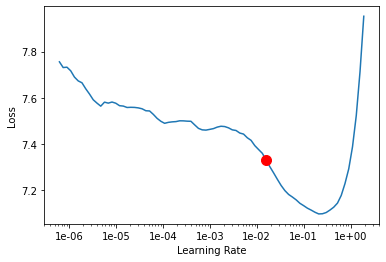

In [46]:
learn.recorder.plot(suggestion = True, skip_end=8)

In [47]:
learn.fit_one_cycle(2, 2.75E-02, moms=(0.8, 0.7), 
       callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = 'best_fit_head')])

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,4.710141,4.485938,0.303743,0,0,1120,2348,30:59
1,4.260427,4.135214,0.332271,0,0,0,2696,31:03


Better model found at epoch 0 with valid_loss value: 4.48593807220459.
Better model found at epoch 1 with valid_loss value: 4.135213851928711.


In [0]:
learn.load(path_mod/"best_fit_head")

In [0]:
learn.unfreeze()

In [50]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-06
Min loss divided by 10: 1.74E-04


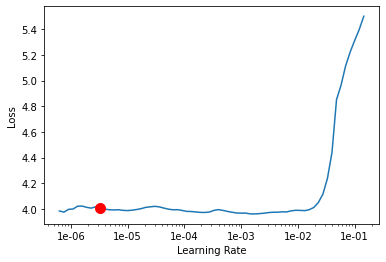

In [53]:
learn.recorder.plot(suggestion = True, skip_end=15)

In [54]:
learn.fit_one_cycle(5, 2.75E-03, moms=(0.8, 0.7), 
       callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = 'best_lm_fine_tuned')])

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,3.893295,3.948941,0.344141,0,0,770,2696,34:35
1,3.906411,3.864715,0.355230,0,0,0,2696,34:40
2,3.724854,3.785601,0.365374,0,0,0,2696,34:41
3,3.499038,3.747781,0.371026,0,0,0,2696,34:42
4,3.277662,3.764797,0.371132,0,0,0,2696,34:40


Better model found at epoch 0 with valid_loss value: 3.948941230773926.
Better model found at epoch 1 with valid_loss value: 3.864715337753296.
Better model found at epoch 2 with valid_loss value: 3.7856009006500244.
Better model found at epoch 3 with valid_loss value: 3.7477810382843018.


In [0]:
learn.load(path_mod/'best_lm_fine_tuned')

In [0]:
learn.save_encoder(path_mod/"best_fine_tuned_enc")

In [0]:
TEXT = "Este usuario ni siquiera llega al rango de"
N_WORDS = 20
N_SENTENCES = 1

In [22]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Este usuario ni siquiera llega al rango de que se cansa . Que odio a la mierda de quien le gusta la forma de darte el ojete


Actual text:
"Este usuario ni siquiera llega al rango de    hereje   . Por lo tanto deberÃ­a ser quemado en la barbacoa para purificar su alma y nuestro aparato digestivo mediante su ingestiÃ³n.    Skipe linkin 22px   Honor, valor, leltad.      17:48 13 mar 2008 (UTC)"

In [0]:
bs = 128
data_clas_train = load_data(path_out, 'data_clas_train.pkl', bs = bs)

In [28]:
%%time
bs = 128
data_clas_train =  (TextList.from_df(train_df, vocab = data_lm.vocab, cols = 1)
                    .split_none()
                    .label_from_df(cols = 0)
                    .databunch(bs = bs))

CPU times: user 2.02 s, sys: 390 ms, total: 2.41 s
Wall time: 15 s


In [29]:
valid_data = TextList.from_df(valid_df, vocab = data_lm.vocab, cols = 1).split_none().label_from_df(cols = 0).databunch(bs = bs)
valid_data

TextClasDataBunch;

Train: LabelList (8000 items)
x: TextList
xxbos xxmaj este usuario ni siquiera llega al rango de xxunk . xxmaj por lo tanto debería ser xxunk en la xxunk para xxunk su alma y nuestro aparato xxunk mediante su xxunk . xxmaj xxunk linkin 22px xxmaj honor , valor , xxunk . xxunk 13 mar 2008 ( xxup utc ),xxbos xxmaj il testo di questa voce pare esser scopiazzato direttamente da qui . xxmaj immagino possano esserci problemi di copyright , nel fare cio .,xxbos xxmaj vale . xxmaj sólo xxunk mi pasado . xxmaj todo tiempo pasado fue mejor , ni mucho menos , yo no quisiera xxunk 31 años a nivel particular . xxmaj las xxunk a pasar putas . xxmaj fernando,xxbos xxmaj bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili xxunk var . xxmaj önerim siyaset bilimi ana başlığından sonra siyasal yaşam ve toplum , siyasal güç , siyasal xxunk , siyasal gruplar , çağdaş xxunk , din , siyasal xxunk , xxunk , propaganda ve siyasal xxunk temelinde xxunk siyas

In [0]:
data_clas_train.valid_dl = valid_data.train_dl

In [0]:
data_clas_train.save(path_out/'data_clas_train.pkl')

In [54]:
data_clas_train

TextClasDataBunch;

Train: LabelList (22355 items)
x: TextList
xxbos " , 22 xxmaj january 2011 ( xxup utc ) 
  xxrep 5 : xxup blp ? xxmaj in any case , although we do n't have a ( credible ; less restrictive than " " reliable " " ) source that it is xxunk , we may have a reliable source that it is accused ( by political opponents ) of being xxunk . xxmaj that might be the most neutral phrasing . — xxunk ",xxbos xxmaj you xxup dl the videos from here actually .. http : / / xxunk / history / xxunk / 
 
  xxunk thousand years ago ? xxmaj what 's the point and what does that have to do with the article or the near east ?,xxbos : : xxmaj you 're a troll . xxmaj delete away .,xxbos " 
 
  xxmaj please do not vandalize pages , as you did with this edit to xxmaj alexander the xxmaj great . xxmaj if you continue to do so , you will be blocked from editing . ",xxbos i reckon there is an argument for it - it is an interesting part of the total package . xxmaj it 's much easier to read here than t

In [0]:
auc_roc_score = AUROC()
learn = text_classifier_learner(data_clas_train, AWD_LSTM, model_dir = path_mod, drop_mult = 0.5, metrics = [accuracy, auc_roc_score], callback_fns=PeakMemMetric).to_fp16()
learn.load_encoder(path_mod/"best_fine_tuned_enc")

In [63]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.20E-01
Min loss divided by 10: 3.63E-02


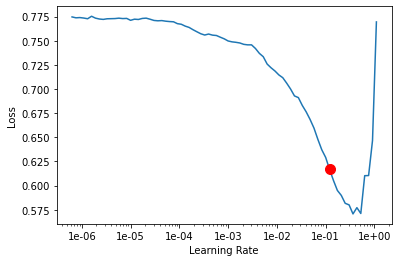

In [68]:
learn.recorder.plot(suggestion = True, skip_end = 8)

In [69]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.12022644346174131

In [70]:
learn.fit_one_cycle(5, min_grad_lr, moms=(0.8, 0.7), 
       callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = 'best_fit_head_clas')])

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time
0,0.205619,0.511786,0.848790,0.702425,15,15,100,3878,02:17
1,0.198300,0.745988,0.847656,0.676351,0,1,-198,5762,02:50
2,0.190545,0.467883,0.848664,0.784522,0,1,100,4450,02:47
3,0.178022,0.517978,0.846396,0.724765,10,10,74,4386,02:26
4,0.176811,0.498382,0.846648,0.732729,0,1,26,4830,02:49


Better model found at epoch 0 with valid_loss value: 0.5117856860160828.
Better model found at epoch 2 with valid_loss value: 0.46788257360458374.


In [0]:
learn.load("best_fit_head_clas")

In [72]:
learn.freeze_to(-2)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-06
Min loss divided by 10: 9.12E-08


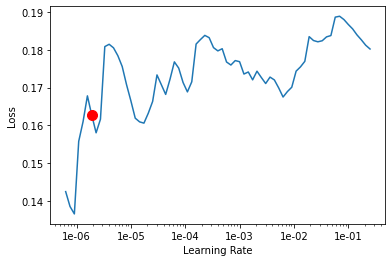

In [73]:
learn.recorder.plot(suggestion = True)

In [74]:
learn.fit_one_cycle(1, slice(1E-03/(2.6**4), 1E-03), moms=(0.8,0.7), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='auroc', name = 'best_fit_minus2_clas')])

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time
0,0.171473,0.482210,0.852571,0.764541,10,10,-708,6832,03:00


Better model found at epoch 0 with auroc value: 0.7645412683486938.


In [24]:
learn.load("best_fit_head_clas")
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1E-02/(2.6**4), 1E-02), moms=(0.8,0.7), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='auroc', name = 'temp')])

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time
0,0.167266,0.443023,0.845892,0.788450,0,1,814,5766,00:36


Better model found at epoch 0 with auroc value: 0.7884501218795776.


In [25]:
learn.load("best_fit_head_clas")
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1E-04/(2.6**4), 1E-04), moms=(0.8,0.7), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='auroc', name = 'temp')])

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time
0,0.180646,0.493090,0.847026,0.789196,0,1,74,6956,00:37


Better model found at epoch 0 with auroc value: 0.7891958355903625.


In [0]:
learn.load("temp")

In [0]:
learn.save('best_fit_minus2_clas')

In [0]:
learn.load('best_fit_minus2_clas')

In [0]:
learn.freeze_to(-3)

In [36]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 8.32E-06
Min loss divided by 10: 1.10E-07


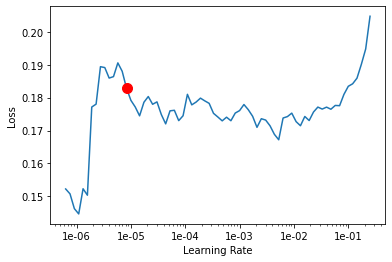

In [37]:
learn.recorder.plot(suggestion = True)

In [38]:
learn.fit_one_cycle(1, slice(1E-02/(2.6**4), 1E-02), moms=(0.8,0.7), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='auroc', name = 'temp')])

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time
0,0.159772,0.437000,0.849546,0.804755,5,5,200,7886,01:01


Better model found at epoch 0 with auroc value: 0.8047545552253723.


In [39]:
learn.load("best_fit_minus2_clas")
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(4E-03/(2.6**4), 4E-03), moms=(0.8,0.7), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='auroc', name = 'temp1')])

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time
0,0.164964,0.468667,0.850050,0.771403,10,10,540,7646,00:54


Better model found at epoch 0 with auroc value: 0.7714028358459473.


In [40]:
learn.load("best_fit_minus2_clas")
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5E-02/(2.6**4), 5E-02), moms=(0.8,0.7), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='auroc', name = 'temp1')])

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time
0,0.156452,0.455121,0.849672,0.828002,0,1,216,8114,01:02


Better model found at epoch 0 with auroc value: 0.8280023336410522.


In [0]:
learn.save("best_fit_minus3_clas")

In [0]:
learn.load("best_fit_minus3_clas")

In [43]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-06
Min loss divided by 10: 6.31E-08


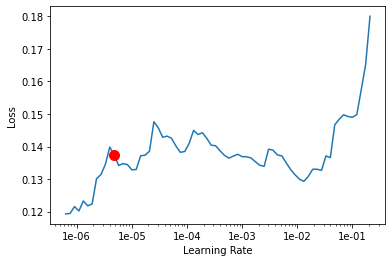

In [44]:
learn.recorder.plot(suggestion = True)

In [45]:
learn.fit_one_cycle(4, slice(2E-03/(2.6**4), 2E-03), moms=(0.8,0.7), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='auroc', name = 'temp')])

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time
0,0.119364,0.501961,0.848790,0.773473,0,1,184,11802,01:18
1,0.098904,0.609254,0.848034,0.745252,10,11,-58,11696,01:10
2,0.076777,0.725421,0.850050,0.728242,0,1,144,10906,01:05
3,0.054845,0.814441,0.849672,0.685794,15,15,-204,10772,01:12


Better model found at epoch 0 with auroc value: 0.7734732627868652.


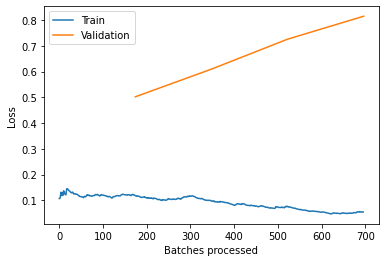

In [46]:
#overfitting
learn.recorder.plot_losses()

In [47]:
learn.load("best_fit_minus3_clas")
learn.unfreeze()
learn.fit_one_cycle(2, slice(2E-03/(2.6**4), 2E-03), moms=(0.8,0.7), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='auroc', name = 'temp')])

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time
0,0.116042,0.538645,0.851941,0.816550,0,1,574,10914,01:02
1,0.105253,0.509376,0.851562,0.805286,0,1,0,12248,01:20


Better model found at epoch 0 with auroc value: 0.8165495991706848.


In [48]:
learn.load("best_fit_minus3_clas")
learn.unfreeze()
learn.fit_one_cycle(2, slice(2E-04, 2E-03), moms=(0.8,0.7), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='auroc', name = 'temp1')])

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time
0,0.115827,0.499359,0.850680,0.810328,10,10,530,11058,01:08
1,0.093512,0.511229,0.851184,0.799039,0,1,-80,12132,01:16


Better model found at epoch 0 with auroc value: 0.8103277683258057.


In [0]:
learn.load("temp")

In [0]:
learn.save("best_clas_fine_tuned")

In [0]:
'''
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
for _, test_index in sss.split(train_df, train_df.toxic):
  sample_df = train_df.loc[test_index]
print(train_df.toxic.value_counts())
print(sample_df.toxic.value_counts())
sample_df.to_csv(path_in/"sample_train.csv", index = False)
df = pd.read_csv(path_in/"sample_train.csv")
df.head()
'''

In [36]:
len(sample_df)

22355

In [37]:
print(train_df.toxic.value_counts())
print(sample_df.toxic.value_counts())

0    202165
1     21384
Name: toxic, dtype: int64
0    20217
1     2138
Name: toxic, dtype: int64


In [40]:
df = pd.read_csv(path_in/"sample_train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0a09f916ce6e77ce,""", 22 January 2011 (UTC) \n :::::BLP? In any ...",0,0,0,0,0,0
1,c27b11ee01f9769d,You DL the videos from here actually.. http://...,0,0,0,0,0,0
2,388e696b7672dc8c,::You're a troll. Delete away.,0,0,0,0,1,0
3,90b401755e15f325,""" \n\n Please do not vandalize pages, as you ...",0,0,0,0,0,0
4,ee66e5bc910e5a36,I reckon there is an argument for it - it is ...,0,0,0,0,0,0
